<a href="https://colab.research.google.com/github/Neo-glitch/kaggle_competitions/blob/main/Kaggle_Titanic_Dataset_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, \
                                    GridSearchCV, RandomizedSearchCV,train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# using sklearn-pandas package
from sklearn_pandas import CategoricalImputer
from sklearn.impute import SimpleImputer

# too reduce dim of features
from sklearn.decomposition import PCA

## Load data from Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"princeneo","key":"3b9d7386bd779e976792802bc36ea840"}'}

In [ ]:
# make a kaggle dir
!mkdir ~/.kaggle

# copies kaggle json to kaggle dir
!cp kaggle.json ~/.kaggle/

# gives permission
! chmod 600 ~/.kaggle/kaggle.json


# copied api command to get kaggle dataset
! kaggle competitions download -c titanic

mkdir: cannot create directory ‘/root/.kaggle’: File exists
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# make titanic dir
!mkdir titanic

!unzip titanic -d titanic

mkdir: cannot create directory ‘titanic’: File exists
Archive:  titanic.zip
replace titanic/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y'
  inflating: titanic/gender_submission.csv  
replace titanic/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: titanic/test.csv        
replace titanic/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: titanic/train.csv       


In [ ]:
train_df = pd.read_csv("/content/titanic/train.csv")

test_df = pd.read_csv("/content/titanic/test.csv")

submission_df = pd.read_csv("/content/titanic/gender_submission.csv")

train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* survival (Survival) =>	0 = No, 1 = Yes
* pclass  	Ticket class => 	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	(Sex) => Male , Female
* Age	(Age in years	)
* sibsp	(# of siblings / spouses aboard the Titanic	)
* parch	(# of parents / children aboard the Titanic	)
* ticket	Ticket number	
* fare	(Passenger fare	)
* cabin	(Cabin number	)
* embarked	(Port of Embarkation) =>	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
# helper to drop col
def drop_column(dataframe, column_list):
    new_df = dataframe.drop(columns = column_list)
    return new_df

# helper to get metrics and store in a dict
# def get_model_score_and_save(y_test, y_pred, clf_name, result_dict):
#     score_dict = {}
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average="macro")
#     recall = recall_score(y_test, y_pred, average="macro")
#     f1 = f1_score(y_test, y_pred, average="macro")
    
#     score_dict["accuracy"] = accuracy
#     score_dict["precision"] = precision
#     score_dict["recall"] = recall
#     score_dict["f1_score"] = f1
    
#     result_dict[clf_name] = score_dict

### EDA and Preprocessing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# to check nan values and col they belong to
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [ ]:
#since passengerId has lowest correlation with y, drop

train_df = drop_column(train_df, ["PassengerId"])

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


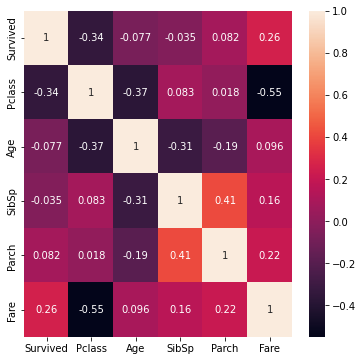

In [ ]:
fig, _ = plt.subplots(figsize = (6,6))

train_corr = train_df.corr()

sns.heatmap(train_corr, annot=True)

# from corr heatmap Pclass and Fare are higly correlated and also Sibsp and Parch have high corr amongst others

In [ ]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# le = LabelEncoder()

# train_df["Sex"] = le.fit_transform(train_df[["Sex"]])



# print(le.classes_) # female : 0 and male : 1

train_df = pd.concat([train_df, pd.get_dummies(train_df[["Sex"]])], axis = 1)

# train_df = drop_column(train_df, ["Sex"])

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [ ]:
# ticket col seems to hold no value, so drop it
train_df = drop_column(train_df, ["Ticket"])

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,0,1


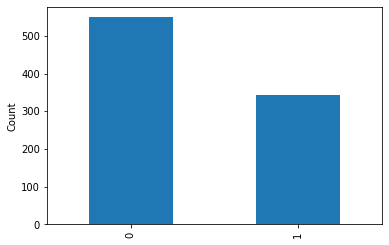

In [ ]:
# see count of survived
plt.ylabel("Count")
train_df["Survived"].value_counts().plot(kind = "bar")

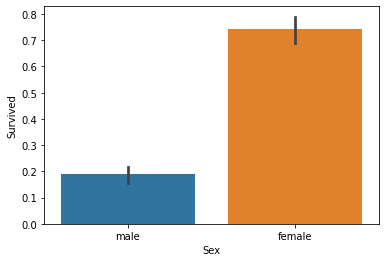

In [ ]:
# see count of female and male that survied
sns.barplot(x = train_df["Sex"], y = train_df["Survived"])

# seen that most female survived compared to men

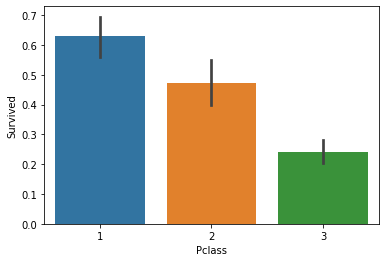

In [ ]:
# see count of survived based on class
sns.barplot(data = train_df, x = "Pclass", y = "Survived")

# first class are more likely to survive

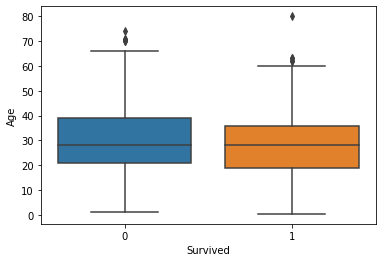

In [ ]:
sns.boxplot(data = train_df, x = "Survived", y = "Age")  # seen that old people have a lesser chance of surviving

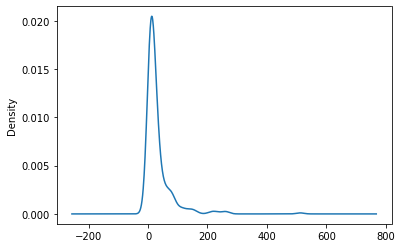

In [ ]:
train_df.Fare.plot(kind='kde') 

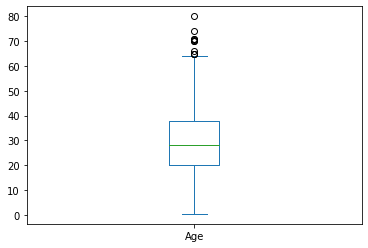

In [ ]:
train_df["Age"].plot(kind = "box") 

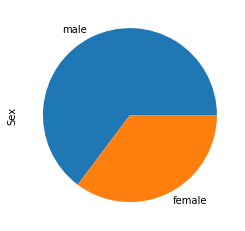

In [ ]:
train_df.Sex.value_counts().plot(kind='pie')  # seen they are more male than female, but yet less male survived.

In [ ]:
# extracts titles to see if title can contribute to predictions
train_df["titles"] = train_df['Name'].str.extract(r', (\w+\.)').values.reshape(-1)

print(f"Unique titles are: {train_df['titles'].unique()}")

# seen that we have found a created a nan row without knowing, will fix that later
train_df.head()

Unique titles are: ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' nan 'Jonkheer.']


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_female,Sex_male,titles
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,0,1,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,1,0,Mrs.
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1,0,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,1,0,Mrs.
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,0,1,Mr.


In [ ]:
# handle nan cols

imputer = CategoricalImputer()
train_df["Embarked"] = imputer.fit_transform(train_df["Embarked"])


simple_imputer = SimpleImputer(strategy = "median") # should have used mean, but Age col has outliers, so best to use median
train_df["Age"] = simple_imputer.fit_transform(train_df["Age"].values.reshape(-1, 1)).reshape(-1)

train_df.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin         687
Embarked        0
Sex_female      0
Sex_male        0
titles          1
dtype: int64

In [ ]:
# drop cabin col, has too many missing values 
# (could comeback and find what to do with this like creating a dummy model to predict value for this)

train_df = drop_column(train_df, ["Cabin"])

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,titles
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,1,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,0,Mrs.
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,0,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,0,Mrs.
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,1,Mr.


In [ ]:
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Sex_female    0
Sex_male      0
titles        1
dtype: int64

In [ ]:
# find row with nan values for title
train_df.query("titles != titles")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,titles
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,86.5,S,1,0,NaN


In [ ]:
print(train_df["titles"].unique())

# after some lil research, seen that she can have title of Lady since female and of royal descent
train_df.loc[759, "titles"] = "Lady"

train_df.isnull().sum()

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' nan 'Jonkheer.']


Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Sex_female    0
Sex_male      0
titles        0
dtype: int64

In [ ]:
# drop name col
train_df = drop_column(train_df, ["Name"])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   Sex_female  891 non-null    uint8  
 9   Sex_male    891 non-null    uint8  
 10  titles      891 non-null    object 
dtypes: float64(2), int64(4), object(3), uint8(2)
memory usage: 64.5+ KB


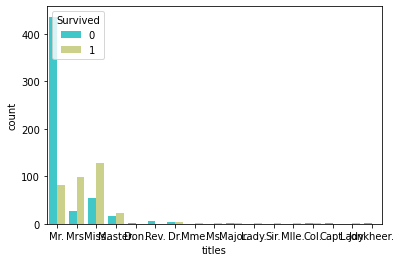

In [ ]:
# as found before most males die in comparison to the ones kept alive
sns.countplot(x='titles',data=train_df, palette='rainbow',hue='Survived')

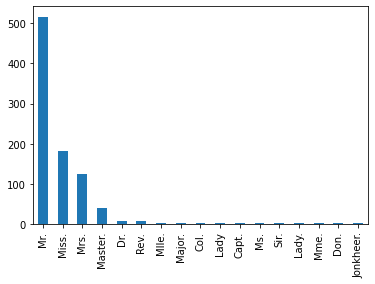

In [ ]:
train_df["titles"].value_counts().plot(kind = "bar")

# seen from distro that top tiles are Mr, Miss, Mrs, Dr. and we can assign last to bin 5
# or better still try with top 3 having own bin and others to be in single bin

In [ ]:
# Encode the remaining cat cols and correlate
# maked embarked cat data to num
# mapping_dict = {
#     "S" : 0,
#     "C" : 1,
#     "Q" : 2
# }

# train_df["Embarked"] = train_df["Embarked"].map(mapping_dict).astype(int)
train_df = pd.concat([train_df, pd.get_dummies(train_df[["Embarked"]])], axis = 1)

train_df = drop_column(train_df, ["Embarked"])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Sex_female  891 non-null    uint8  
 8   Sex_male    891 non-null    uint8  
 9   titles      891 non-null    object 
 10  Embarked_C  891 non-null    uint8  
 11  Embarked_Q  891 non-null    uint8  
 12  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), object(2), uint8(5)
memory usage: 60.2+ KB


In [ ]:
# le = LabelEncoder()

# # since so manuy features for titles, we just bin most frquent class to individual class and map all the other rare classes to a single class
# train_df["titles"] = le.fit_transform(train_df[["titles"]])

# train_df.info()

# changed

train_df.titles.unique()

# helper to do the bining work for us
def filter_to_bin(title):

  if title in ["Mr."]:
    return 'Mr.'

  elif title in ['Mrs.']:
    return 'Mrs.'

  elif title in ['Miss.']:
    return 'Miss.'
  
  elif title in ["Master."]:
    return "Master."

  else:
    return "others"


train_df["titles"] = train_df["titles"].apply(filter_to_bin)

train_df["titles"].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'others'], dtype=object)

In [ ]:
# one hot encode the bins
train_df = pd.concat([train_df, pd.get_dummies(train_df[["titles"]])], axis = 1)

train_df = drop_column(train_df, ["titles"])

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_others
0,0,3,male,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0
1,1,1,female,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0
2,1,3,female,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0
3,1,1,female,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1,0
4,0,3,male,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0


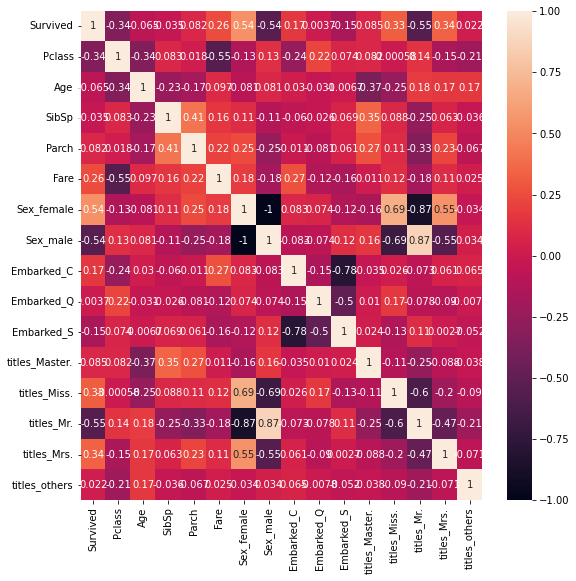

In [ ]:
fig, _ = plt.subplots(figsize = (9,9))

sns.heatmap(train_df.corr(), annot = True)

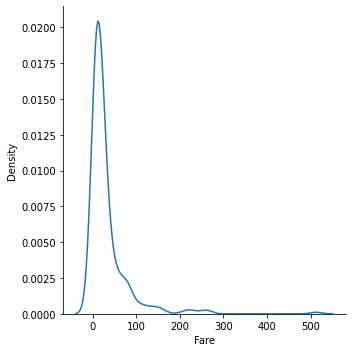

In [ ]:
# thinking to bin this, but let's see
sns.displot(kind = "kde", x = "Fare", data = train_df)

In [ ]:
# combine sibsp and parch to form familyCount
train_df["familyCount"] = train_df["SibSp"] + train_df["Parch"] + 1 # 1 for the person in question

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_others,familyCount
0,0,3,male,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,2
1,1,1,female,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,2
2,1,3,female,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1,0,2
4,0,3,male,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,1


In [ ]:
# drop the Sex column, since we aren't using it for anything
# and also Sibsp and Parch since covered by the FamilyCount Col
train_df = drop_column(train_df, ["Sex"])
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_others,familyCount
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,2
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,2
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1,0,2
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,1


In [ ]:
x = train_df.drop(columns = ["Survived"])
y = train_df["Survived"]

x.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_others,familyCount
0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,2
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,2
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0,1


In [ ]:
# split x data into cat and numerical columns and scale numerical cols

x_numerical = x[["Age", "Fare", "familyCount", "SibSp", "Parch"]]

x_cat = drop_column(x, ["Age", "Fare", "familyCount", "SibSp", "Parch"])

x_numerical.head()

# robust_scaler = RobustScaler()
# robust_scaler.fit_transform(x_numerical)

,Age,Fare,familyCount,SibSp,Parch
0,22.0,7.2500,2,1,0
1,38.0,71.2833,2,1,0
2,26.0,7.9250,1,0,0
3,35.0,53.1000,2,1,0
4,35.0,8.0500,1,0,0


In [ ]:
std_scaler = StandardScaler()

x_numerical_scaled = pd.DataFrame(std_scaler.fit_transform(x_numerical), columns = ["Age", "Fare", "familyCount", "SibSp", "Parch"])

x_numerical_scaled.head(3)

,Age,Fare,familyCount,SibSp,Parch
0,-0.565736,-0.502445,0.059160,0.432793,-0.473674
1,0.663861,0.786845,0.059160,0.432793,-0.473674
2,-0.258337,-0.488854,-0.560975,-0.474545,-0.473674


In [ ]:
# join both dataframes back
x_scaled = pd.concat([x_numerical_scaled, x_cat], axis = 1)

In [ ]:
x_scaled.columns

Index(['Age', 'Fare', 'familyCount', 'SibSp', 'Parch', 'Pclass', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'titles_Master.',
       'titles_Miss.', 'titles_Mr.', 'titles_Mrs.', 'titles_others'],
      dtype='object')

## Model Training and Evaluation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size = 0.02)

# not_survived_class_weight = y.value_counts()[0]/ y.value_counts().sum()
# survived_class_weight = y.value_counts()[1]/ y.value_counts().sum()

random_trees = RandomForestClassifier(n_estimators = 450, max_depth=15, max_leaf_nodes=16, 
                                      random_state=100, n_jobs = -1, class_weight={0:0.616, 1:0.384})

# random_trees.fit(x_train, y_train)

cross_val_score(random_trees, x_scaled, y, cv = 5)

# base line is this : [0.84916201, 0.82022472, 0.85955056, 0.79213483, 0.86516854]

array([0.84916201, 0.82022472, 0.85955056, 0.79213483, 0.86516854])

### Model Prediction on test_data

In [ ]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_others,familyCount,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,0,1,0,0,1,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,0,0,1,0,2,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,0,1,0,0,1,0,1,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,0,1,0,0,1,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,0,0,1,0,3,0,0,1,1,0


In [ ]:
test_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
titles_Master.    0
titles_Miss.      0
titles_Mr.        0
titles_Mrs.       0
titles_others     0
familyCount       0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Sex_female        0
Sex_male          0
dtype: int64

In [ ]:
# drop cabin col
test_df = drop_column(test_df, ["Cabin"])

test_df.head()

KeyError: ignored

In [ ]:
test_df["Fare"].plot(kind = "box")  # box data is highly skewed, due to outliers in filling nans use median instrad of mean

In [ ]:
test_df["Age"].plot(kind="box")  # not much outlier, but still use median to be consitent with train_data

In [ ]:
simple_im = SimpleImputer(strategy="median")

test_df["Age"] = simple_imputer.fit_transform(test_df["Age"].values.reshape(-1, 1)).reshape(-1)

test_df["Fare"] = simple_imputer.fit_transform(test_df["Fare"].values.reshape(-1, 1)).reshape(-1)

test_df.head()

In [ ]:
test_df.isnull().sum()

In [ ]:
test_df["titles"] = test_df['Name'].str.extract(r', (\w+\.)').values.reshape(-1)

test_df.isnull().sum()

In [ ]:
# bin titles

test_df["titles"] = test_df["titles"].apply(filter_to_bin)

test_df["titles"].unique()

In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df[["titles"]])], axis = 1)

test_df = drop_column(test_df, ["titles"])

test_df.head()

In [ ]:
test_df["familyCount"] = test_df["SibSp"] + test_df["Parch"] + 1 # 1 for the person in question

test_df.head()

In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df[["Embarked"]])], axis = 1)

test_df = drop_column(test_df, ["Embarked"])

In [ ]:
test_df.head(3)

In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df[["Sex"]])], axis = 1)

# needed for submission 
passenger_id = test_df["PassengerId"]

test_df.head()

In [ ]:
x_test = test_df[['Age', 'Fare', 'familyCount', 'SibSp', 'Parch', 'Pclass', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'titles_Master.',
       'titles_Miss.', 'titles_Mr.', 'titles_Mrs.', 'titles_others']]

x_test      

In [ ]:
x_test_numerical = x_test[["Age", "Fare", "familyCount", "SibSp", "Parch"]]

x_test_cat = drop_column(x_test, ["Age", "Fare", "familyCount", "SibSp", "Parch"])

x_test_numerical.head()

In [ ]:
std_scaler = StandardScaler()

x_test_numerical_scaled = pd.DataFrame(std_scaler.fit_transform(x_test_numerical), columns = ["Age", "Fare", "familyCount", "SibSp", "Parch"])

x_test_scaled = pd.concat([x_test_numerical_scaled, x_test_cat], axis = 1)

x_test_scaled.head()

In [ ]:
predictions = random_trees.predict(x_test_scaled)


submission = pd.DataFrame({
    "PassengerId": passenger_id,
    "Survived": predictions
})

submission.head(4)

In [ ]:
submission.to_csv("titanic_submission.csv", index = False)